<a href="https://colab.research.google.com/github/Joe-brands/stage-f-10-police-shootings/blob/master/Police_shooting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [85]:
!ls "/content/gdrive/My Drive"

'Colab Notebooks'		   kaggle		       shootings.csv
 household_power_consumption.zip  'my kaggle screenshot.jpg'


In [86]:
!ls "/content"

gdrive	sample_data


In [87]:
import numpy as np
import pandas as pd
import datetime

In [88]:
data = pd.read_csv('/content/gdrive/My Drive/shootings.csv')
data.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,Asian,Shelton,WA,True,attack,Not fleeing,False,Guns
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,White,Aloha,OR,False,attack,Not fleeing,False,Guns
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,Hispanic,Wichita,KS,False,other,Not fleeing,False,Unarmed
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,White,San Francisco,CA,True,attack,Not fleeing,False,Other unusual objects
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,Hispanic,Evans,CO,False,attack,Not fleeing,False,Piercing objects


In [89]:
data.shape

(4895, 15)

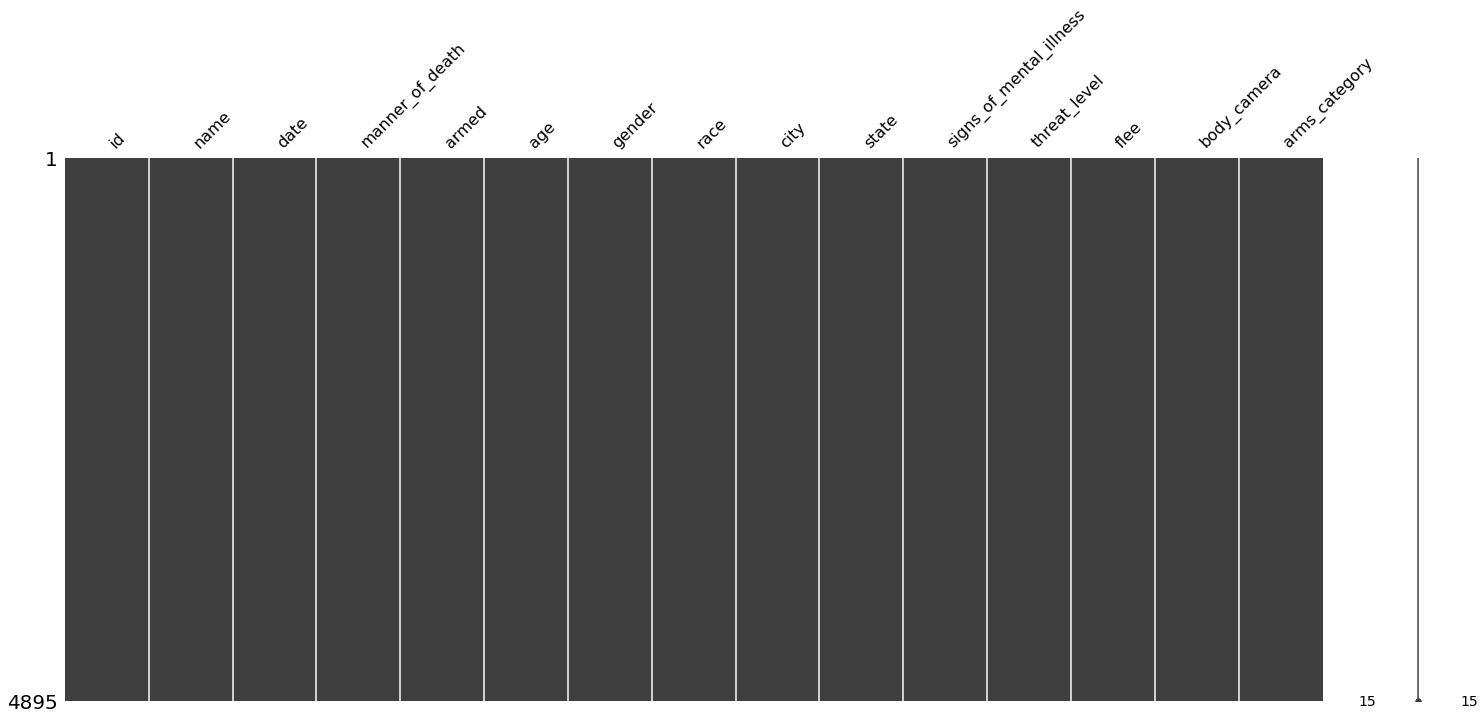

In [90]:
import missingno as msno
msno.matrix(data)

In [91]:
# Converting date to datetime

data['day'] = pd.DatetimeIndex(data['date']).day
data['month'] = pd.DatetimeIndex(data['date']).month
data['year'] = pd.DatetimeIndex(data['date']).year

data.head(2)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category,day,month,year
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,Asian,Shelton,WA,True,attack,Not fleeing,False,Guns,2,1,2015
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,White,Aloha,OR,False,attack,Not fleeing,False,Guns,2,1,2015


In [92]:
def f(row):
  '''
  Function that will be used to create the target column of two classes 1 and 0.
  Where 1 represents the unjustified cases and 0 represents the just ones. 
  '''
  if ((row['threat_level']=='undetermined' or row['threat_level']=='other') and (row['flee']=='Not fleeing')):
        val = 1
    
  else:
        val = 0
  return val

# Applying the function
data['label'] = data.apply(f, axis=1)

In [93]:

data['label'].value_counts()

0    3829
1    1066
Name: label, dtype: int64

In [94]:

# Train and test df
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, test_size=0.20, random_state=100)

In [95]:
# encoding categorical columns
from sklearn.preprocessing import LabelEncoder
cat_cols = ['armed','city','state','manner_of_death','gender','race','signs_of_mental_illness',
             'year','threat_level','flee','body_camera','arms_category']
encoder = LabelEncoder()

# Apply label encoder to each column
encoded = data[cat_cols].apply(encoder.fit_transform)

In [96]:
encoded.head(2)

,armed,city,state,manner_of_death,gender,race,signs_of_mental_illness,year,threat_level,flee,body_camera,arms_category
0,35,1889,47,0,1,0,1,0,0,2,0,3
1,35,33,37,0,1,5,0,0,0,2,0,3


In [97]:

# join some important data features with the encoded variables
df = data[['name','date','age','label']].join(encoded)
df.head()

,name,date,age,label,armed,city,state,manner_of_death,gender,race,signs_of_mental_illness,year,threat_level,flee,body_camera,arms_category
0,Tim Elliot,2015-01-02,53.0,0,35,1889,47,0,1,0,1,0,0,2,0,3
1,Lewis Lee Lembke,2015-01-02,47.0,0,35,33,37,0,1,5,0,0,0,2,0,3
2,John Paul Quintero,2015-01-03,23.0,1,81,2236,16,1,1,2,0,0,1,2,0,9
3,Matthew Hoffman,2015-01-04,32.0,0,80,1826,4,0,1,5,1,0,0,2,0,6
4,Michael Rodriguez,2015-01-04,39.0,0,59,647,5,0,1,2,0,0,0,2,0,7


In [98]:
df_copy = df.copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4895 entries, 0 to 4894
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     4895 non-null   object 
 1   date                     4895 non-null   object 
 2   age                      4895 non-null   float64
 3   label                    4895 non-null   int64  
 4   armed                    4895 non-null   int64  
 5   city                     4895 non-null   int64  
 6   state                    4895 non-null   int64  
 7   manner_of_death          4895 non-null   int64  
 8   gender                   4895 non-null   int64  
 9   race                     4895 non-null   int64  
 10  signs_of_mental_illness  4895 non-null   int64  
 11  year                     4895 non-null   int64  
 12  threat_level             4895 non-null   int64  
 13  flee                     4895 non-null   int64  
 14  body_camera             

In [99]:
df_copy.shape

(4895, 16)

**Model Building**

In [100]:
import warnings
warnings.filterwarnings('ignore') 

from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [101]:
train, test = train_test_split(df_copy, test_size=0.20, random_state=100)
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (3916, 16)
test shape: (979, 16)


In [102]:
train = shuffle(train)

train_features = train.drop(columns=['name','date','label'])
train_target = train['label']

test_features = test.drop(columns=['name','date','label'])
test_target = test['label']

In [103]:
train_target.value_counts()

0    3072
1     844
Name: label, dtype: int64

In [104]:
# Oversampling the undersampled labels
import imblearn
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X, y = smote.fit_sample(train_features, train_target)

# converting ndarray to dataframe
X = pd.DataFrame(X, columns=train_features.columns)
y = pd.Series(y, name=train_target.name)

In [105]:
X.head()

,age,armed,city,state,manner_of_death,gender,race,signs_of_mental_illness,year,threat_level,flee,body_camera,arms_category
0,29.0,35.0,1424.0,34.0,0.0,1.0,1.0,0.0,4.0,0.0,2.0,1.0,3.0
1,42.0,86.0,1727.0,4.0,1.0,1.0,3.0,1.0,4.0,1.0,1.0,0.0,0.0
2,54.0,35.0,531.0,30.0,0.0,1.0,5.0,1.0,0.0,0.0,2.0,0.0,3.0
3,26.0,82.0,936.0,35.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,10.0
4,40.0,35.0,1652.0,9.0,0.0,1.0,2.0,0.0,5.0,0.0,0.0,0.0,3.0


In [106]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [107]:
from numpy import zeros
from numpy import asarray
from numpy import load
from numpy import ones
from numpy import asarray
from sklearn.model_selection import train_test_split

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import backend
from keras.applications.vgg16 import VGG16
from keras.models import Model
import tensorflow as tf
import keras
from keras import backend as K
from sklearn.metrics import accuracy_score

In [108]:
lg = LogisticRegression(random_state=32)
lg.fit(train_features, train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=32, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [109]:
lg_test_pred = lg.predict_proba(test_features)

In [110]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(test_target, lg_test_pred[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(test_target))]
p_fpr, p_tpr, _ = roc_curve(test_target, random_probs, pos_label=1)

In [111]:
# auc scores
auc_score1 = roc_auc_score(test_target, lg_test_pred[:,1])

print(auc_score1)

0.9373534697180668


In [112]:
batch_size = 128  # Batch size for training.
epochs = 10  # Number of epochs to train for.

model = Sequential()
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.2, noise_shape=None, seed=None))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.2, noise_shape=None, seed=None))
model.add(Dense(train['label'].nunique(), activation='softmax'))

from keras.optimizers import Adam

optimizer = RMSprop(learning_rate=0.001)
#optimizer = Adam(0.0001, decay=0.00001)

 
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(train_features, train_target, epochs=epochs, batch_size=batch_size, validation_data=(test_features, test_target))


Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

31/31 [==============================] - 0s 8ms/step - loss: 7.1222 - accuracy: 0.4990 - val_loss: 7.1289 - val_accuracy: 0.2268
Epoch 2/10
31/31 [==============================] - 0s 3ms/step - loss: 6.9709 - accuracy: 0.6578 - val_loss: 4.3878 - val_accuracy: 0.4831
Epoch 3/10
31/31 [==============================] - 0s 3ms/step - loss: 6.9893 - accuracy: 0.6034 - val_loss: 6.6650 - val_accuracy: 0.7354
Epoch 4/10
31/31 [==============================] - 0s 3ms/step - loss: 6.9322 - accurac

**Make predictions**

In [113]:
new_pred = model.predict_proba(test_features)

In [114]:
# roc curve for models
fpr2, tpr2, thresh2 = roc_curve(test_target, new_pred[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(test_target))]
p_fpr, p_tpr, _ = roc_curve(test_target, random_probs, pos_label=1)

In [115]:
# auc scores
auc_score2 = roc_auc_score(test_target, new_pred[:,1])

print(auc_score2)

0.5119812679257858


In [116]:

pred_result = test_df.copy()
pred_result['label'] = lg_test_pred[:,1]
unjustified_shots = pred_result[pred_result['label']>=0.6]

In [117]:

# Names of suspects whose shots were predicted as unjust, and their dates of occurance
unjustified_shots[['name','date']]

,name,date
2048,Jacob Taulbee,2017-02-26
2230,Jaison Fitzgerald,2017-05-15
731,Matthew Dobbins,2015-10-02
3123,Shukri Ali Said,2018-04-28
1136,Brandon Stanley,2016-03-04
...,...,...
3690,Juston Landry,2019-01-11
1629,Robert Carrillo,2016-09-15
167,Monique Jenee Deckard,2015-03-08
2738,Mario Guevara,2017-12-02


In [118]:
pred_result = test_df.copy()
pred_result['label'] = new_pred[:,1]
unjustified_shots = pred_result[pred_result['label']>=0.6]

In [119]:

# Names of suspects whose shots were predicted as unjust, and their dates of occurance
unjustified_shots[['name','date']]

,name,date
416,QuanDavier Hicks,2015-06-09
2866,Michael Hansford,2018-01-29
1043,Bruce Kelley,2016-01-31
2350,Holden Gorka,2017-07-03
3426,Timmy Henley,2018-09-04
...,...,...
3757,Danny Rodriguez,2019-02-07
3291,Craig Yelton,2018-07-08
2738,Mario Guevara,2017-12-02
970,Eric John Senegal,2016-01-04
